# Chapter 4. Geospatial data

In this session, we will introduced the `gdal` geospatial module which can read a wide range of scientific data formats. You will find that using it to read data is quite similar to the work we did last week on netCDF datasets.

The main challenges are also much the same: very often, you need to be able to read data from a 'stack' of image files and generate a useful 3D (space and time) dataset from these. Once you have the data in such a form, there are *many* things we can do with it, and very many of these are convenient to do using array-based expressions such as in numpy (consider the simplicity of the expression `absorbed = rad * (1 - albedo)` from last week's exercise). 

That said, it can sometimes be quite an effort to prepare datasets in this form. Last week, we developed a 'valid data' mask from the GlobAlbedo dataset, as invalid data were stored as `nan`. Very often though, scientific datasets have more complex 'Quality Control' (QC) information, that gives per-pixel information describing the quality of the product at that location (e.g. it was very cloudy so the results are not so good).

To explore this, we will first consider the [MODIS Leaf Area Index (LAI)](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a2) product that is mapped at 1 km resolution, every 8 days from the year 2000.

We will learn how to read in these data (in `hdf` format) using `gdal`, and how to interpret the QC information in such products to produce valid data masks. As an exercise, you will wrap some code around that to form a 3D masked array of the dataset.

Next, we will consider how to download such data. This should be a reinforcement of material from last week, but it is useful to know how to conveniently access NASA data products. A challenge in the exercise then is to download a different dataset (MODIS snow cover) for the UK, and form a masked 3D dataset from this.

Finally, we will introduce vector datasets and show you python tools that allow you (among many other things) to build a mask in the projection and sampling of your spatial dataset (MODIS LAI in this case).

There are many features and as many complexities to the Python tools we will deal with today, but in this material, we cover some very typical tasks you will want to do. They all revolve around generating masked 3D datasets from NASA MODIS datasets, which is a very useful form of global biophysical information over the last decade+. We also provide much material for further reading and use when you are more confident in your programming.

A final point here is that the material we cover today is very closely related to what you will need to do in the first section of your assessed practical that we will introduce next week, so you really need to get to grips with this now.

There is not as much 'new' material as in previous weeks now, but we assume that you have understood, and can make use of, material from those lectures.

First, we will examine data from a NASA MODIS product on Leaf Area Index (LAI).

- 4.1 [MODIS LAI product](#4.1-MODIS-LAI-product)
- 4.2 [Downloading data](#4.2-Downloading-data)  
- 4.3 [Vector masking](#4.3-Vector-masking)

## 4.1 MODIS LAI product

GDAL covers a much wider set of file formats and methods than the netCDF library that we previously used.

Basic operation involves:

- load gdal 
- open a spatial dataset (an hdf format file here)
- specify which subsets you want.

We can explore the subsets in the file with `GetSubDatasets()`:

In [1]:
# how to find out which datasets are in the file

import gdal # Import GDAL library bindings
%matplotlib inline
import numpy as np
import pylab as plt

# The file that we shall be using
# Needs to be on current directory
filename = 'data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf'

g = gdal.Open(filename)
# g should now be a GDAL dataset, but if the file isn't found
# g will be none. Let's test this:
if g is None:
    print "Problem opening file %s!" % filename
else:
    print "File %s opened fine" % filename
    
    
subdatasets = g.GetSubDatasets()
for fname, name in subdatasets:
    print name
    print "\t", fname



File data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf opened fine
[1200x1200] Fpar_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Fpar_1km
[1200x1200] Lai_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Lai_1km
[1200x1200] FparLai_QC MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparLai_QC
[1200x1200] FparExtra_QC MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparExtra_QC
[1200x1200] FparStdDev_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparStdDev_1km
[1200x1200] LaiStdDev_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A201

In the previous code snippet we have done a number of different things:

1. Import the GDAL library
2. Open a file with GDAL, storing a handler to the file in `g`
3. Test that `g` is not `None` (as this indicates failure opening the file. Try changing `filename` above to something else)
4. We then use the `GetSubDatasets()` method to read out information on the different subdatasets available from this file (compare to the output of `gdalinfo` on the shelf earlier)
5. Loop over the retrieved subdatasets to print the name (human-readable information) and the GDAL filename. This last item is the filename that you need to use to tell GDAL to open a particular data layer of the 6 layers present in this example

Let's say that we want to access the LAI information. By contrasting the output of the above code (or `gdalinfo`) to the contents of the [LAI/fAPAR product information page](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a2), we find out that we want the layers for `Lai_1km`, `FparLai_Qc`, `FparExtra_QC` and `LaiStdDev_1km`. 

To read these individual datasets, we need to open each of them individually using GDAL, and the GDAL filenames used above:

In [2]:
# How to access specific datasets in gdal

# Let's create a list with the selected layer names
selected_layers = [  "Lai_1km", "FparLai_QC", "LaiStdDev_1km" ]

# We will store the data in a dictionary
# Initialise an empty dictionary
data = {}

# for convenience, we will use string substitution to create a 
# template for GDAL filenames, which we'll substitute on the fly:
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
# This has two substitutions (the %s parts) which will refer to:
# - the filename
# - the data layer

for i, layer in enumerate ( selected_layers ):
    this_file = file_template % ( filename, layer )
    print "Opening Layer %d: %s" % (i+1, this_file )
    g = gdal.Open ( this_file )
    
    if g is None:
        raise IOError
    data[layer] = g.ReadAsArray() 
    print "\t>>> Read %s!" % layer
    

Opening Layer 1: HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Lai_1km
	>>> Read Lai_1km!
Opening Layer 2: HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparLai_QC
	>>> Read FparLai_QC!
Opening Layer 3: HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:LaiStdDev_1km
	>>> Read LaiStdDev_1km!


In the previous code, we have seen a way of neatly creating the filenames required by GDAL to access the independent datasets: a template string that gets substituted with the `filename` and the `layer` name. Note that the presence of double quotes in the template requires us to use single quotes around it. The data is now stored in a dictionary, and can be accessed as e.g. `data['Lai_1km']` which is a numpy array:

In [3]:
type(data['Lai_1km'])

numpy.ndarray

In [4]:
print data['Lai_1km']

[[ 3  3  2 ...,  6  8 21]
 [ 4  3  6 ...,  8 18 14]
 [ 3 12 11 ..., 12  8  8]
 ..., 
 [ 2  3  2 ..., 18 11 17]
 [ 2  3  3 ..., 16 19 15]
 [ 3  2  2 ..., 15 16 15]]


Now we have to translate the LAI values into meaningful quantities. According to the [LAI](https://lpdaac.usgs.gov/products/modis_products_table/leaf_area_index_fraction_of_photosynthetically_active_radiation/8_day_l4_global_1km/mod15a2) webpage, there is a scale factor of 0.1 involved for LAI and SD LAI:

In [5]:
lai = data['Lai_1km'] * 0.1
lai_sd = data['LaiStdDev_1km'] * 0.1

In [6]:
print "LAI"
print lai
print "SD"
print lai_sd

LAI
[[ 0.3  0.3  0.2 ...,  0.6  0.8  2.1]
 [ 0.4  0.3  0.6 ...,  0.8  1.8  1.4]
 [ 0.3  1.2  1.1 ...,  1.2  0.8  0.8]
 ..., 
 [ 0.2  0.3  0.2 ...,  1.8  1.1  1.7]
 [ 0.2  0.3  0.3 ...,  1.6  1.9  1.5]
 [ 0.3  0.2  0.2 ...,  1.5  1.6  1.5]]
SD
[[ 0.2  0.2  0.1 ...,  0.2  0.1  0.3]
 [ 0.2  0.2  0.2 ...,  0.2  0.3  0.2]
 [ 0.   0.1  0.2 ...,  0.1  0.2  0.2]
 ..., 
 [ 0.1  0.1  0.1 ...,  0.3  0.   0.1]
 [ 0.1  0.1  0.1 ...,  0.2  0.2  0.1]
 [ 0.1  0.1  0.1 ...,  0.1  0.2  0.1]]


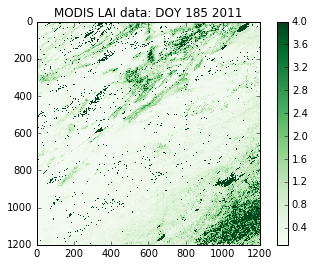

In [7]:
# plot the LAI

import pylab as plt

# colormap
cmap = plt.cm.Greens

plt.imshow(lai,interpolation='none',vmin=0.1,vmax=4.,cmap=cmap)
plt.title('MODIS LAI data: DOY 185 2011')
plt.colorbar()

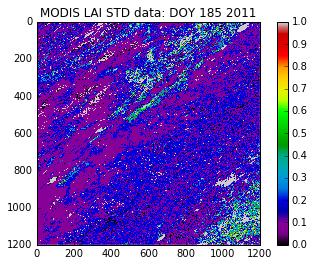

In [8]:
# plot the LAI std

import pylab as plt

# colormap
cmap = plt.cm.spectral
# this sets the no data colour. 'k' is black

plt.imshow(lai_sd,interpolation='none',vmax=1.,cmap=cmap)
plt.title('MODIS LAI STD data: DOY 185 2011')
plt.colorbar()

It is not possible to produce LAI estimates if it is persistently cloudy, so the dataset may contain some gaps.

These are identified in the dataset using the QC (Quality Control) information.

We should then examine this. 

The codes for this are also given on the LAI product page. They are described as bit combinations:

<table>
<tr>
<th>Bit No.</th>	<th>Parameter Name</th><th>	Bit Combination</th><th>Explanation</th>
<tr>
<td>0	</td><td>MODLAND_QC bits</td><td>	0</td><td>	Good quality (main algorithm with or without saturation)	 	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Other Quality (back-up algorithm or fill values)	 	 </td>
</tr>

<tr>
<td>1	</td><td>Sensor</td><td>	0</td><td>	TERRA</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>AQUA</td>
</tr>

<tr>
<td>2	</td><td>DeadDetector</td><td>	0</td><td>	Detectors apparently fine for up to 50% of channels 1	2	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Dead detectors caused >50% adjacent detector retrieval</td>
</tr>

<tr>
<td>3-4</td><td>CloudState</td><td>	00</td><td>	Significant clouds NOT present (clear)	 	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	01	</td><td>Significant clouds WERE present</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	10	</td><td>Mixed clouds present on pixel</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	11	</td><td>Cloud state not defined assumed clear</td>
</tr>

<tr>
<td>5-7</td><td>CF_QC</td><td>	000</td><td>	Main (RT) method used	best result possible (no saturation)	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	001	</td><td>Main (RT) method used with saturation. Good	very usable</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	010	</td><td>Main (RT) method failed due to bad geometry	empirical algorithm used</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	011	</td><td> Main (RT) method failed due to problems other than geometry	empirical algorithm used</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	100	</td><td> Pixel not produced at all	value coudn’t be retrieved (possible reasons: bad L1B data	unusable MODAGAGG data)</td>
</tr>
</table>

In using this information, it is up to the use which data he/she wants to pass through for any further processing. There are clearly trade-offs: if you look for only the highest quality data, then the number of samples is likely to be lower than if you were more tolerant. But if you are too tolerant, you will get spurious results. 



But let's just say that we want to use only the highest quality data. 

This means we want bit 0 to be 0 ...

Let's have a look at the QC data:

In [9]:
qc = data['FparLai_QC'] # Get the QC data which is an unsigned 8 bit byte
print qc , qc.dtype

[[2 2 0 ..., 0 2 2]
 [2 2 0 ..., 2 0 2]
 [0 2 0 ..., 0 0 0]
 ..., 
 [0 0 2 ..., 0 8 0]
 [0 0 0 ..., 0 0 2]
 [0 2 0 ..., 2 2 2]] uint8


We see various byte values:

In [10]:
np.unique(qc)

array([  0,   2,   8,  10,  16,  18,  32,  34,  40,  42,  48,  50,  97,
        99, 105, 107, 113, 115, 157], dtype=uint8)

In [11]:
# translated into binary using bin()
for i in np.unique(qc):
    print i,bin(i)

0 0b0
2 0b10
8 0b1000
10 0b1010
16 0b10000
18 0b10010
32 0b100000
34 0b100010
40 0b101000
42 0b101010
48 0b110000
50 0b110010
97 0b1100001
99 0b1100011
105 0b1101001
107 0b1101011
113 0b1110001
115 0b1110011
157 0b10011101


We could try to come up with an interpretation of each of these ... or we could try to mask the qc bytes to see bit 0 only if that's what we are interested in. This is quite possibly a new concept for most of you, but it is very common that when interpreting QC data in data products, you need to think about bit masking. You will find more details on this in the advanced section of Chapter 1, but we will consider the minimum we need right now.

Byte data are formed of 8 bits, e.g.:

`
105 ==  (1 * 2**6) + 
        (1 * 2**5) + 
        (0 * 2**4) + 
        (1 * 2**3) + 
        (0 * 2**2) + 
        (0 * 2**1) + 
        (1 * 2**0)`


So, in binary, we represent the decimal number `105` by `1101001` as we saw above.

The QC values are to be interpreted in this manner.

If we want *only* bit 1, we can perform a *bitwise* operation with the byte data.

In this case, it would be an 'and' operation (`&`) with the value `1`:

In [12]:
# suppose we consider the value 105
# which from above, we know to have 
# bit 0 set as 1
test = 105
bit_zero = test & 1
print bit_zero

1


In [13]:
# suppose we consider the value 104
# which we could work out has bit 1 as 0
test = 104
bit_zero = test & 1
print bit_zero

0


In [14]:
# other bit fields are a 'little' more complicated
tests = np.unique(qc)


for t in tests:
    # if we want bit field 5-7
    # we form a binary mask
    mask57 = 0b11100000
    # but 0
    mask0 =  0b00000001
    # and use & as before and right shift 5 (>> 5)
    qa57 = (t & mask57) >> 5
    qa0  = (t & mask0) >> 0
    print t,qa57,qa0,bin(t)

0 0 0 0b0
2 0 0 0b10
8 0 0 0b1000
10 0 0 0b1010
16 0 0 0b10000
18 0 0 0b10010
32 1 0 0b100000
34 1 0 0b100010
40 1 0 0b101000
42 1 0 0b101010
48 1 0 0b110000
50 1 0 0b110010
97 3 1 0b1100001
99 3 1 0b1100011
105 3 1 0b1101001
107 3 1 0b1101011
113 3 1 0b1110001
115 3 1 0b1110011
157 4 1 0b10011101


So, for example (examining the table above) `105` is interpreted at `0b011` in fields 5 to 7 (which is 3 in decimal). This indicates that 'Main (RT) method failed due to problems other than geometry empirical algorithm used'. Here, bit zero is set to `1`, so this is a 'bad' pixel.

In this case, we are only interested in bit 0, which is an easier task than inmterpreting all of the bits.

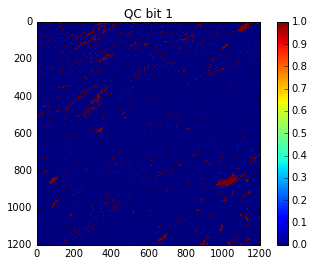

In [15]:
# the good data are where qc bit 1 is 0

qc = data['FparLai_QC'] # Get the QC data
# find bit 0
qc = qc & 1

plt.imshow(qc)
plt.title('QC bit 1')
plt.colorbar()

We can use this mask to generate a masked array. Masked arrays, as we have seen before, are like normal arrays, but they have an associated mask. 

Remember that the mask in a masked array should be `False` for good data, so we can directly use `qc` as defined above. 

We shall also choose another colormap (there are [lots to choose from](http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps)), and set values outside the 0.1 and 4 to be shown as black pixels.

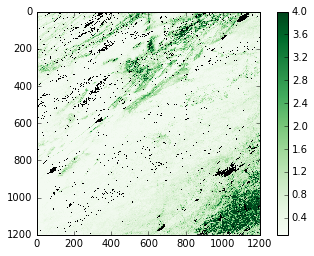

In [16]:
# colormap
cmap = plt.cm.Greens
cmap.set_bad ( 'k' )
# this sets the no data colour. 'k' is black

# generate the masked array
laim = np.ma.array ( lai, mask=qc )

# and plot it
plt.imshow ( laim, cmap=cmap, interpolation='none', vmin=0.1, vmax=4)
plt.colorbar()

Similarly, we can do a similar thing for Standard Deviation

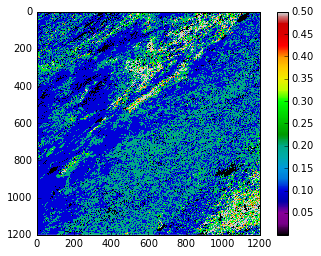

In [17]:
cmap = plt.cm.spectral
cmap.set_bad ( 'k' )
stdm = np.ma.array ( lai_sd, mask=qc )
plt.imshow ( stdm, cmap=cmap, interpolation='none', vmin=0.001, vmax=0.5)
plt.colorbar()

For convenience, we might wrap all of this up into a function:

In [18]:
import gdal
import numpy as np
import numpy.ma as ma


def getLAI(filename, \
           qc_layer = 'FparLai_QC',\
           scale = [0.1, 0.1],\
           selected_layers = ["Lai_1km", "LaiStdDev_1km"]):
           
    # get the QC layer too
    selected_layers.append(qc_layer)
    scale.append(1)
    # We will store the data in a dictionary
    # Initialise an empty dictionary
    data = {}
    # for convenience, we will use string substitution to create a 
    # template for GDAL filenames, which we'll substitute on the fly:
    file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
    # This has two substitutions (the %s parts) which will refer to:
    # - the filename
    # - the data layer
    for i,layer in enumerate(selected_layers):
        this_file = file_template % ( filename, layer )
        g = gdal.Open ( this_file )
        
        if g is None:
            raise IOError
        
        data[layer] = g.ReadAsArray() * scale[i]

    qc = data[qc_layer] # Get the QC data
    # find bit 0
    qc = qc & 1
    
    odata = {}
    for layer in selected_layers[:-1]:
        odata[layer] = ma.array(data[layer],mask=qc)
    
    return odata
    

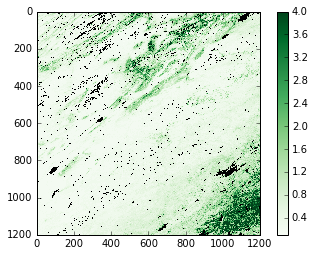

In [19]:
filename = 'data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf'

lai_data = getLAI(filename)

# colormap
cmap = plt.cm.Greens
cmap.set_bad ( 'k' )
# this sets the no data colour. 'k' is black

# and plot it
plt.imshow ( lai_data['Lai_1km'], cmap=cmap, interpolation='nearest', vmin=0.1, vmax=4)
plt.colorbar()

## Exercise 4.1

You are given the MODIS LAI data files for the year 2012 in the directory `data` for the UK (MODIS tile h17v03).

Read these LAI datasets into a masked array, using QA bit 0 to mask the data (i.e. good quality data only) and generate a movie of LAI.

You should end up with something like:

![](files/images/lai_uk02.gif)

## 4.2 Downloading data

For the exercise and notes above, you were supplied with several datasets that had been previously downloaded.

### 4.2.1 Reverb

These NASA data can be accessed in several ways (except on Wednesdays when they go down for maintainance (or when there is a Government shutdown ...)). The most direct way is to use [Reverb](http://reverb.echo.nasa.gov/reverb/#utf8=%E2%9C%93&spatial_map=satellite&spatial_type=rectangle) to explore and access data. If you do this, you can, for example [search for MODIS snow cover MOD10 datasets covering the UK](http://reverb.echo.nasa.gov/reverb/#utf8=%E2%9C%93&spatial_map=satellite&spatial_type=rectangle&spatial=47.517%2C%202.813%2C%2056.907%2C%20-10.547&keywords=modis%20snow%20cover%20mod10&temporal_start=2013-02-21%2000%3A00%3A00&temporal_end=2013-03-21%2023%3A59%3A59) for some given time period. If you follow this through, e.g. selecting [MODIS/Terra Snow Cover Daily L3 Global 500m SIN Grid V005](http://reverb.echo.nasa.gov/reverb/granules?utf8=%E2%9C%93&new_view=true&spatial_map=satellite&spatial_type=rectangle&spatial=47.517%2C+2.813%2C+56.907%2C+-10.547&keywords=modis+snow+cover+mod10&temporal_start=2013-02-21+00%3A00%3A00&temporal_end=2013-03-21+23%3A59%3A59&datasets=C92711294-NSIDC_ECS) and then search for 'granules', you should get access to the datasets you want (select e.g. one of the files for gid `h17v03` and save to cart). You then view the items in your cart, click 'download' and then 'FTP Batch Script'.

This should give you a text file with some urls in it, e.g.:

    open n5eil01u.ecs.nsidc.org
    user anonymous user@example.com
    bin
    get DP5/MOST/MOD10A1.006/2013.02.21/MOD10A1.A2013052.h18v03.006.2016137181439.hdf MOD10A1.A2013052.h18v03.006.2016137181439.hdf
    close
    bye

The hdf dataset is, in this case `ftp://n5eil01u.ecs.nsidc.org/DP5/MOST/MOD10A1.006/2013.02.21/MOD10A1.A2013052.h18v03.006.2016137181439.hdf`.

From this, we see that the data server is `n5eil01u.ecs.nsidc.org` (the actual server used will vary from time to time: if the links supplied do not work, go through reverb and work out what the new server is) and that the MODIS snow products for the MODIS Terra instrument are in the directory:

`ftp://n5eil01u.ecs.nsidc.org/DP0/MOST`.

If we explored that, we would find the datasets from the MODIS Aqua platform were in:

`ftp://n5eil01u.ecs.nsidc.org/DP0/MOSA`.

The directories below that give the date and filename.

### 4.2.2 FTP access

Now we have discovered something about the directory structure on the server, we could explore this to get the datasets we want (rather than having to go through Reverb).

Some of the datasets on Reverb are acessible only through `http`, but the snow products (at present) are availble by `ftp`.

In either case, if we want to run some 'batch' process to download many files (e.g. all files for a year for some tile), the first thing we need is the set of urls for the files we want.

We won't go into detail here about how to get this, but it is covered in the advanced section (at the very least, you could always get the set of urls from Reverb).

So, let's suppose now that we have a file containing some urls that we want to pull:


In [ ]:
# see https://docs.python.org/2/library/ftplib.html
from ftplib import FTP

'''
A utility function that sets
the global value to what is passed into x

We need this for accessing the filename from the ftp 
with wildcards
'''
value = None
def getval(x):
    global value
    print x
    value = x

url_site = 'n5eil01u.ecs.nsidc.org'

ftp = FTP(url_site)
ftp.login() 
print 'logged in'
info = {'YEAR':2007,'MONTH':1,'DAY':1}

wd = 'MOSA/MYD10A1.006/{YEAR}.{MONTH:02d}.{DAY:02d}/'.format(**info)
ofile = 'data/MYD.h09v05.{YEAR}.{MONTH:02d}.{DAY:02d}.006.hdf'.format(**info)

# change directory to wd
ftp.cwd(wd) 
# get the filename
ftp.retrlines('LIST MYD*h09v05.006*hdf',getval)
# pull the file and save to ofile
print 'getting binary file'
ftp.retrbinary('RETR '+value.split()[-1],open(ofile, 'wb').write)

# check file is there
import gdal
print 'opening'
g = gdal.Open(ofile)
print g

## Exercise 4.2 A Different Dataset

We have now dowloaded a different dataset, the [MOD10A product](http://www.icess.ucsb.edu/modis/SnowUsrGuide/usrguide_1dtil.html), which is the 500 m MODIS daily snow cover product, over the UK.

This is a good opportunity to see if you can apply what was learned above about interpreting QC information and using `gdal` to examine a dataset.

If you examine the [data description page](http://nsidc.org/data/docs/daac/modis_v5/mod10a1_modis_terra_snow_daily_global_500m_grid.gd.html), you will see that the data are in HDF EOS format (the same as the LAI product). 

### E4.2.1 Download

Download the MODIS Terra daily snow product for the UK for the year 2012 for the month of February using the urls in [data/robot_snow.2012.txt](data/robot_snow.2012.txt) and put them in the directory `data`.

### E4.2.1 Explore

Show all of the subset data layers in this dataset. 

### E4.3.3 Read a dataset

Suppose we are interested in the dataset `Fractional_Snow_Cover` over the land surface.

Read this dataset for one of the files into a numpy array and show a plot of the dataset.

### E4.3.4 Water mask


The [data description page](http://nsidc.org/data/docs/daac/modis_v5/mod10a1_modis_terra_snow_daily_global_500m_grid.gd.html) tells us that values of `239` will indicate whether the data is ocean. You can use this information to build the water mask.

Demonstrate how to build a water mask from one of these files, setting the mask `False` for land and `True` for water. 

Produce a plot of this.

### E3.4.5 Valid pixel mask

As well as having a land/water mask, we should generate a mask for valid pixels. For the snow dataset, values between 0 and 100 (inclusive) represent valid snow cover data values. Other values are not valid for some reason. Set the mask to `False` for valid pixels and `True` for others. Produce a plot of the mask. 


### E4.3.6 3D dataset

Generate a 3D masked numpy array using the valid pixel mask for masking, of `Fractional_Snow_Cover` for each day of February 2012. 

You might like to produce a movie of the result.

Hint: you will need a list of filenames for this. You can either use `glob` as in previous exercises, or you might notice that you have the file `data/robot_snow.2012_MOST_h17v03_02.txt` with the urls, from which you should be able to derive the file names. However you get your list of filenames, you should probably apply a `sort()` to the result to make sure they are in the correct order.


## 4.3 Vector masking

In this section, we will use a pre-defined function to generate a mask from some vector boundary data.

In this case, we will generate a mask for Ireland, projected into the coordinate system of the  MODIS LAI dataset, and use that to generate a new LAI data only for Ireland.

Sometimes, geospatial data is acquired and recorded for particular geometric objects such as polygons or lines. An example is a road layout, where each road is represented as a geometric object (a line, with points given in a geographical projection), with a number of added *features* associated with it, such as the road name, whether it is a toll road, or whether it is dual-carriageway, etc. This data is quite different to a raster, where the entire scene is tessellated into pixels, and each pixel holds a value (or an array of value in the case of multiband rasterfiles). 

If you are familiar with databases, vector files are effectively a database, where one of the fields is a geometry object (a line in our previous road example, or a polygon if you consider a cadastral system). We can thus select different records by writing queries on the features. Some of these queries might be spatial (e.g. check whether a point is inside a particular country polygon).

The most common format for vector data is the **ESRI Shapfile**, which is a multifile format (i.e., several files are needed in order to access the data). We'll start by getting hold of a shapefile that contains the countries of the world as polygons, together with information on country name, capital name, population, etc. The file is available [here](http://aprsworld.net/gisdata/world/world.zip).

![World](http://aprsworld.net/gisdata/world/political-world-aprs-small.png)

We will download the file with wget (or curl if you want to), and uncompress it using unzip in the shell:

In [ ]:
# Downloads the data using wget
!wget -nc http://aprsworld.net/gisdata/world/world.zip -O data/world.zip
# or if you want to use curl...
#! curl http://aprsworld.net/gisdata/world/world.zip -o world.zip
!pushd data;unzip -o -x world.zip;popd

We need to import `ogr`, and then open the file. As with GDAL, we get a handler to the file, (`g` in this case). OGR files can have different layers, although Shapefiles only have one. We need to select the layer using `GetLayer(0)` (selecting the first layer).

In [ ]:
from osgeo import ogr

g = ogr.Open( "data/world.shp" )
layer = g.GetLayer( 0 )

In order to see a field (the field `NAME`) we can loop over the features in the layer, and use the `GetField('NAME')` method. We'll only do ten features here:

In [ ]:
n_feat = 0
for feat in layer:
    
    print feat.GetField('NAME')
    
    n_feat += 1
    if n_feat == 10:
        break

If you wanted to see the different layers, we could do this using:

In [ ]:
layerDefinition = layer.GetLayerDefn()


for i in range(layerDefinition.GetFieldCount()):
    print "Field %d: %s" % ( i+1, layerDefinition.GetFieldDefn(i).GetName() )

There is much more information on using `ogr` on the associated [notebook OGR_Python](OGR_Python.ipynb) that you should explore at some point.

One thing we may often wish to dowith such vector datsets is produce a mask, e.g. for national boundaries. One of the complexities of this is changing the projection that the vector data come in to that of the raster dataset.  

This is too involved to go over in this session, so we will simply present you with a function to achieve this.

This is available as [python/raster_mask.py](python/raster_mask.py).

Most of the code below should be familiar from above (we make use of the `getLAI()` function we developed).

In [ ]:
import sys
sys.path.insert(0,'python')
from raster_mask import raster_mask,getLAI

# have to make sure have access to gdal data files 
import os
if 'GDAL_DATA' not in os.environ:
    os.environ["GDAL_DATA"] = '/opt/anaconda/share/gdal'

# test this on an LAI file

# the data file name
filename = 'data/MCD15A2.A2012273.h17v03.005.2012297134400.hdf'

# a layer (doesn't matter so much which: use for geometry info)
layer = 'Lai_1km'
# the full dataset specification
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template%(filename,layer)

# make a raster mask
# from the layer IRELAND in world.shp
mask = raster_mask(file_spec,\
                   target_vector_file = "data/world.shp",\
                   attribute_filter = "NAME = 'IRELAND'")
plt.imshow(mask)
# get the LAI data
data = getLAI(filename)

# reset the data mask
# 'mask' is True for Ireland
# so take the opposite 
data['Lai_1km'] = ma.array(data['Lai_1km'],mask=mask)
data['LaiStdDev_1km'] = ma.array(data['Lai_1km'],mask=mask)

plt.title('LAI for Eire: 2012273')
plt.imshow(data['Lai_1km'],vmax=6)
plt.colorbar()

## Exercise 4.3

Apply the concepts above to generate a 3D masked numpy data array of LAI and std LAI for Eire for the year 2012.

Plot your results and make a move of LAI.

Plot average LAI for Eire as a function of day of year for 2012.

# Summary

In this session, we have learned to use some geospatial tools using GDAL in Python. A good set of [working notes on how to use GDAL](http://jgomezdans.github.io/gdal_notes/) has been developed that you will find useful for further reading, as well as looking at the [advanced](advanced.ipynb) section.

We have also very briefly introduced dealing with vector datasets in `ogr`, but this was mainly through the use of a pre-defined function that will take an ESRI shapefile (vector dataset), warp this to the projection of a raster dataset, and produce a mask for a given layer in the vector file.

If there is time in the class, we will develop some exercises to examine the datasets we have generated and/or to explore some different datasets or different locations.
